# Cluster Algorithms

We saw that the Metropolis algorithm with local updates provided a way to sample the configurations of the Ising Model.  At this point, it would now seem natural to use our Metropolis code to sample the properties of the Ising Model.  We could then learn quite a bit about ordering and phase transitions.

There is, however, one caveat.  We found that the correlation time of the Markov Chain could be quite long:  For a 64x64 system, at some temperatures we found correlation times which were many thousands of steps.  Things get worse if we look at larger systems.  

Rather than working hard to tell the story with our current code, we will look at a better algorithm.  I should emphasize that we do not *need* a better algorithm.  The one we have suffices to explore a lot of interesting physics.  On the other hand, this is a *computational physics* course, so we should learn how to do better.

The first step in coming up with a better algorithm is to understand why our current algorithm bogs down.  The basic issue has to do with the types of moves which are accepted at moderate or low temperatures:  Energetically, it is very expensive to flip a spin in the middle of a uniform domain.  It is however much cheaper to flip a spin on a domain wall.  Thus the dynamics are dominated by moves which cause the domain walls to diffuse around.

The problem is that when the domains get large, sequential flips tend to fight eachother.  One flip tugs a domain wall in one direction.  The next one tugs it in another.  You need to get a whole bunch of correlated moves in order to actually change a large domain.

The answer is to make correlated moves, where one tries to flip large numbers of spins at once.

In [1]:
using GLMakie
using CairoMakie
using OffsetArrays
using Random
using ProgressMeter
using Statistics

rand_ising2d(m=128, n=m) = rand(Int8[-1, 1], m, n)

"""
    isingprobs(β,h,numneighbors)

returns a 2D array of probabilities, `probflip[σ,τ]` which is the
probability of flipping a spin if site `i` is in state `σ`, and `τ` is the sum of the 
neighbor spins.  Here `sigma` is `1` or `-1` and `τ` goes from `-numneighbors` to `numneighbors`. 

``P_{\\rm flip}(\\sigma,\\tau)= e^{-2 \\beta  \\sigma \\tau -2 \\beta h \\sigma}``
"""
isingprobs(β,h=0,numneighbors=4)=
    OffsetArray([exp(-2*β*(τ+h)*σ) for σ in -1:1, τ in -numneighbors:numneighbors],
    -1:1,-numneighbors:numneighbors)

function randlocalupdate!(s,probflip,numsweeps)
    m, n = size(s)
    @inbounds for sweep in 1:numsweeps*m*n
        # Choose random spin
        i=rand(1:m)
        j=rand(1:n)
        # Find environment
        τ₁=s[mod1(i-1,m),j]
        τ₂=s[mod1(i+1,m),j]
        τ₃=s[i,mod1(j-1,n)]
        τ₄=s[i,mod1(j+1,n)]
        τ=τ₁+τ₂+τ₃+τ₄
        σ=s[i,j]
        # Propose flip
        if rand()<probflip[σ,τ]
            s[i,j]=-σ
        end
    end
    return s
end

struct isingparams
    β ::Float64
    h ::Float64
end

function randlocalupdate!(s,numsweeps,p::isingparams)
    probflip=isingprobs(p.β,p.h)
    randlocalupdate!(s,probflip,numsweeps)
end

GLMakie.activate!() #switch from Cairo to GL backend

mutable struct Isingviz
    s
    β
    h
    probflip

# inner constructor
function Isingviz(m=2^8,n=m)
    viz=new()
    # set up GLMakie window
    fig = Figure(); display(fig)
    ax = Axis(fig[1,1])
    ax.title = "Metropolis -- Local update"
    ax.aspect = DataAspect() 
    # Generate Ising Model
    s_obs=Observable(rand_ising2d(m,n))
    s=s_obs[]
    viz.s=s
    #  Display Ising Model
    image!(ax,s_obs,interpolate=false)
    # run button
    isrunning_obs = Observable(false)
    label = map(cond -> cond ? "Stop" : "Run", isrunning_obs)
    run = Button(fig[2,1]; label = label, tellwidth = false)
    on(run.clicks) do clicks; isrunning_obs[] = !isrunning_obs[]; end
    # Make Sliders
    β=0.43
    h=0
    viz.β=β
    viz.h=h
    probflip=isingprobs(β,h)
    viz.probflip=probflip
    sg=SliderGrid(fig[1,2],
        (label="β",range=0.1:0.01:1,format = "{:.2f}",
                startvalue=β),
        (label="h",range=-0.5:0.05:0.5,format = "{:.2f}",startvalue=h),
        (label="log₂(τ)",range=0:1:10,startvalue=3),
        width=400,tellheight=false)
    β_obs=sg.sliders[1].value;
    h_obs=sg.sliders[2].value;
    on(β_obs)  do β_obs
        viz.β=β_obs[]
        probflip.=isingprobs(viz.β,viz.h)
    end
    on(h_obs)  do h_obs
        viz.h=h_obs[]
        probflip.=isingprobs(viz.β,viz.h)
    end
    stepsize_obs=sg.sliders[3].value;
    #
    # Simulation
    #
    Makie.deactivate_interaction!(ax, :rectanglezoom)
    isrunning_notifier = Condition()
    on(cond -> cond && notify(isrunning_notifier), isrunning_obs)
        errormonitor(@async while true
            if isrunning_obs[]
                isopen(fig.scene) || break # stops if window is closed
                randlocalupdate!(s,probflip,2^stepsize_obs[])
                notify(s_obs)
                yield()
            else
                wait(isrunning_notifier)
            end
        end)
    return viz
end

end
    

In [6]:
viz1=Isingviz()

Isingviz(Int8[1 1 … -1 -1; 1 -1 … -1 -1; … ; -1 1 … 1 -1; -1 -1 … -1 1], 0.43, 0, [0.03206468532786077 0.07577400402284548 … 13.197138159658358 31.18695816830946; 1.0 1.0 … 1.0 1.0; 31.18695816830946 13.197138159658358 … 0.07577400402284548 0.03206468532786077])

The slowdown occurs near the phase transition, where large domains are found.  This is referred to as "critical slowing down."  Although the Monte Carlo dynamics are unphysical, there are analogies betweeen the rules we are using, and the physical laws of motion.  Most importantly, they are both local.  This locality means that physical magnets also display longer relaxation times near the phase transition.

## Wolff Algorithm

Today I will introduce a very clever cluster algorithm which automatically chooses the cluster sizes for the correlated spin flips.  You will code it.

We will once again use a Markov Chain.  Recall that to sample a distribution with a Markov chain we require that:

(1) **The move-set is ergodic:**  We can reach any state from any other state in a finite number of moves.

(2) **The moves obey detailed ballance:**  If we have a move from $i$ to $f$, then the transition rates satisfy
\begin{equation}
p_i \Gamma_{i\to f} =p_f \Gamma_{f\to i}.
\end{equation}
Typically we use the Metropolis rules here: $\Gamma$'s 
\begin{equation}
\Gamma_{i\to f}=\rm{min}\left(\frac{p_f}{p_i},1\right).
\end{equation}



The idea in the Wolff algorithm is that we will generate and flip a random cluster.  There is no rejection step.  Detailed balance comes from the way we construct the cluster.

Here is a summary of the algorithm, in the way we will implement it:

1. A random spin is chosen.  Record the direction of that first spin as `σ`.  Flip that spin. 
2.  Find all of the neighbors of that spin.  Their locations can be stored in any data structure which allows us to easily add and remove elements.  Julia `Vectors` (1D arrays) have this ability, and are pretty efficient to work with.  We will use them as a `Stack`, using the `push!` and `pop!` commands to add and remove elements.  
3. We remove a neighbor from the `Stack`.  If it is not pointing in the direction $\sigma$, we throw it away.  We keep repeating until either the `Stack` is empty, or we find a neighbor pointing in the same direction of `σ`.
4. If we have found a spin pointing in the right direction, we flip it with probability:
  
\begin{align}
P&=
1-e^{-2\beta J}\\
&=1-\bar P,
\end{align}

5. If we end up flipping it, we also add its neighbors to the `Stack`
6. We go back to 3 -- repeating until the `Stack` is empty.


Lets see why this works:

First -- it clearly is Ergodic.  There is a probability of flipping a single spin -- and we can get to any configuration by flipping individual spins.

Second -- suppose we flip a cluster, $C$.  The probability of that flip was $P_C$.  Imagine that after that move we picked exactly the same starting spin, and grew the cluster in exactly the same way -- reversing the cluster, and bringing us back to the starting configuration.  The probability of this reverse move is $P_{\bar C}$.

For both the forward and backward move, the probability of adding one of the spins that end up in the cluster is the same, $1-P$.  The only difference between the forward and backward move is the rejected "boundary" terms.

Without loss of generality, lets assume that the forward move started with an initially $\uparrow$ spin.  Any $\uparrow$ boundary spins are excluded from the forward cluster with $100\%$ probability.  In the backward move, they are excluded with probability $\bar P$.  Similarly, the $\downarrow$ boundary spins are excluded from the forward move with probability $\bar P$, while they are excluded from the backward move with probability $1$.  Thus we see that
\begin{align}
\frac{P_C}{P_{\bar C}} &=\frac{\prod_{\sigma\in\partial} \delta_{\sigma,\downarrow} \bar P}
{\prod_{\sigma\in\partial} \delta_{\sigma,\uparrow} \bar P}\\
&=\exp\left(2\beta J\sum_{\sigma\in\partial}\sigma\right)\\
&=\exp\left(-\beta \Delta E\right).
\end{align}
And we obey detailed balance.

An example will help make this clear.

Lets begin by laying out a spin configuration

In [2]:
CairoMakie.activate!()

In [2]:
spins= [1 -1 -1 -1
        1 -1 -1 -1
        1 -1 -1 1
        1 1 1 1]
start=copy(spins)
c=Dict(1=>RGBf(0.8, 0.8, 0.8),-1=>RGBf(0.,0.,0.))
fig=Figure()
ax=Axis(fig[1, 1],aspect=DataAspect())
function pixel!(loc,color,fontcolor)
    poly!(ax,Point2f[loc, loc.+(1,0), loc.+(1,1), loc.+(0, 1),loc],
        color=color,strokecolor=:white,strokewidth=1)
    text!(ax,loc.+(0.5,0.5),text=string(loc),
        color=fontcolor,align = (:center, :center))
end
for i in CartesianIndices(spins)
    pixel!(i.I,c[start[i]],RGBf(1,0,0))
end
display(fig)

GLMakie.Screen(...)

Now, lets suppose we randomly choose the spin at (3,2) to flip

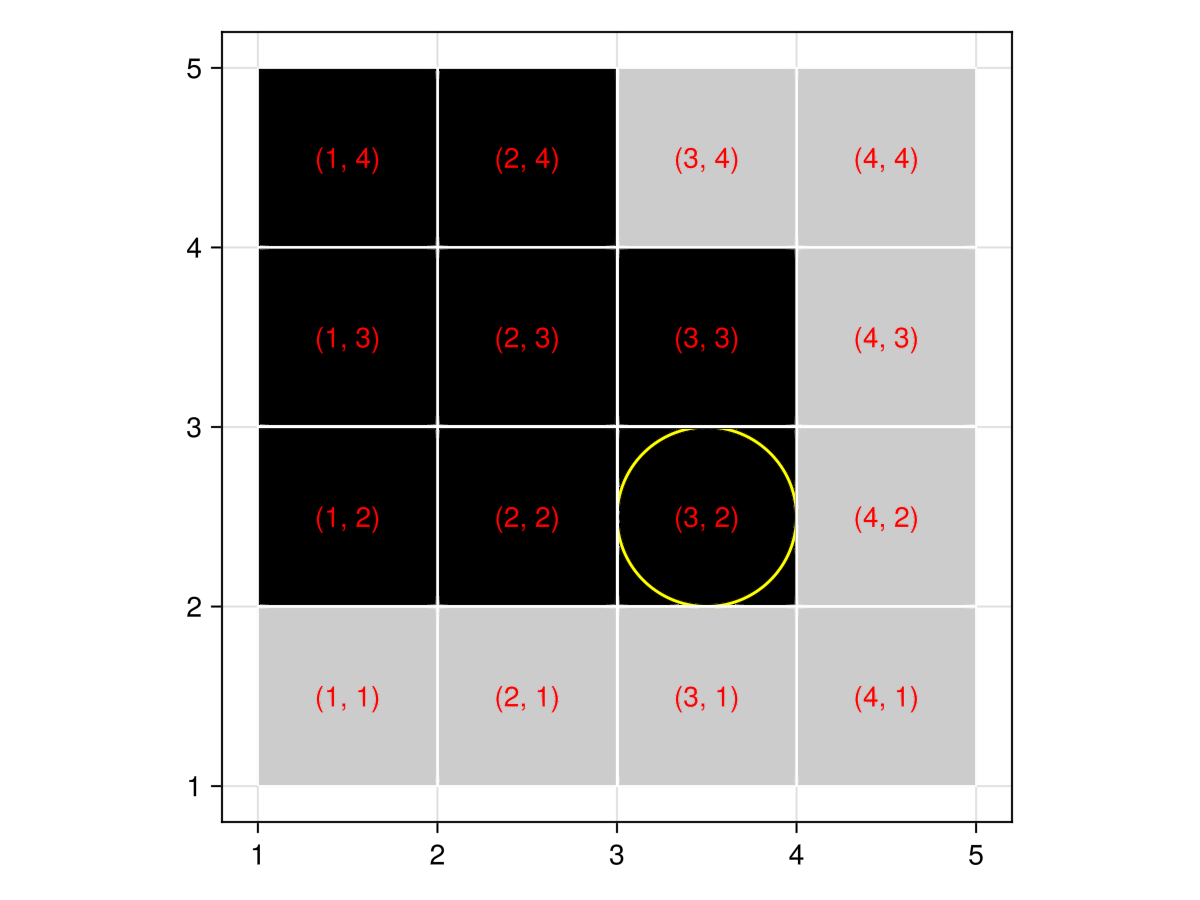

In [3]:
loc=(3,2)
arc!(ax,loc.+(0.5,0.5),0.5,0,2*pi,color=RGBf(1,1,0))
fig

Following the instructions, we flip that spin and record its direction

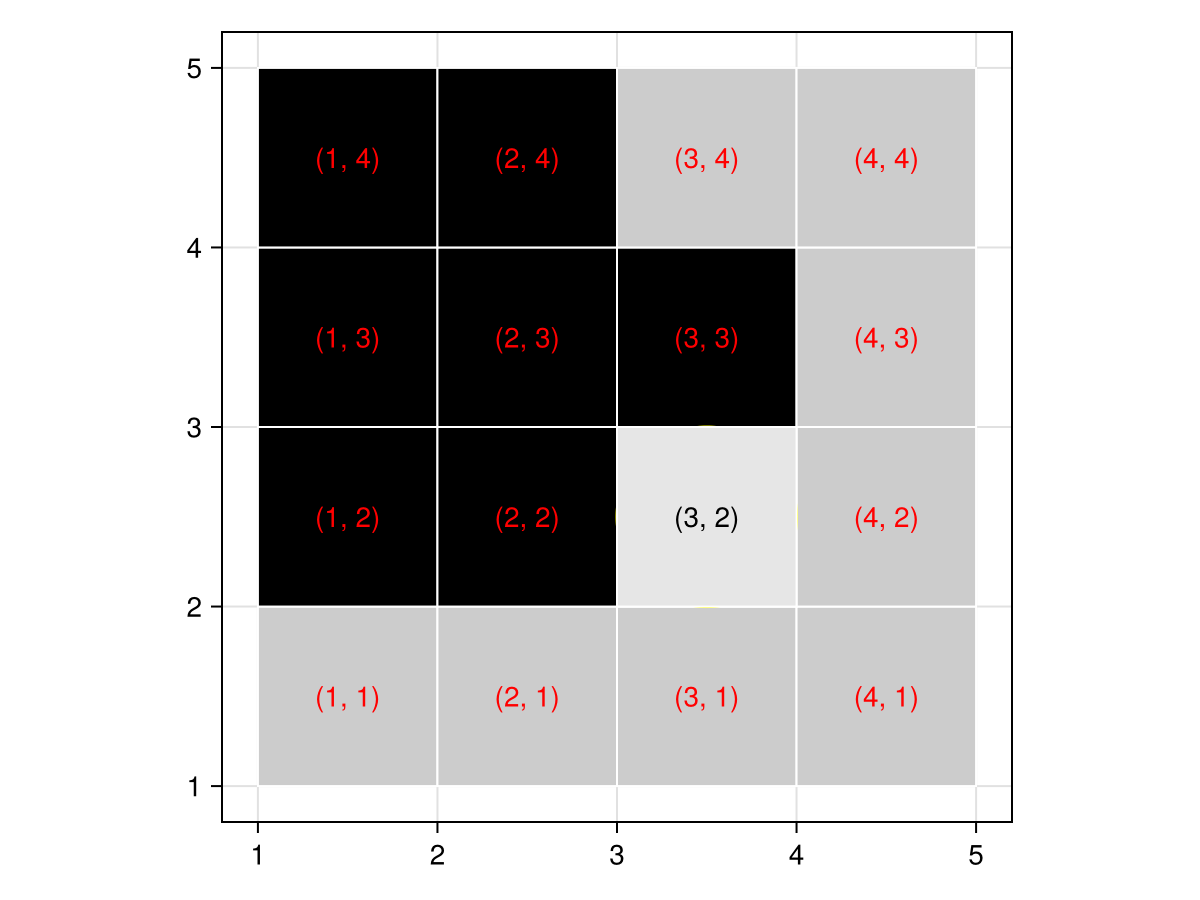

In [45]:
σ=spins[loc...]
spins[loc...]=-σ
pixel!(loc,RGBf(0.9,0.9,0.9),:black)
fig

We then put the neighbors in an Array

In [46]:
neighbors=Array{Tuple{Int32,Int32}}(undef,0)
function addneighbors!(n,l)
    push!(n,l.+(-1,0))
    push!(n,l.+(0,1))
    push!(n,l.+(1,0))
    push!(n,l.+(0,-1))
end
addneighbors!(neighbors,loc)

4-element Vector{Tuple{Int32, Int32}}:
 (2, 2)
 (3, 3)
 (4, 2)
 (3, 1)

(Note, when we put this into practice we will need to account for the periodic boundary conditions)

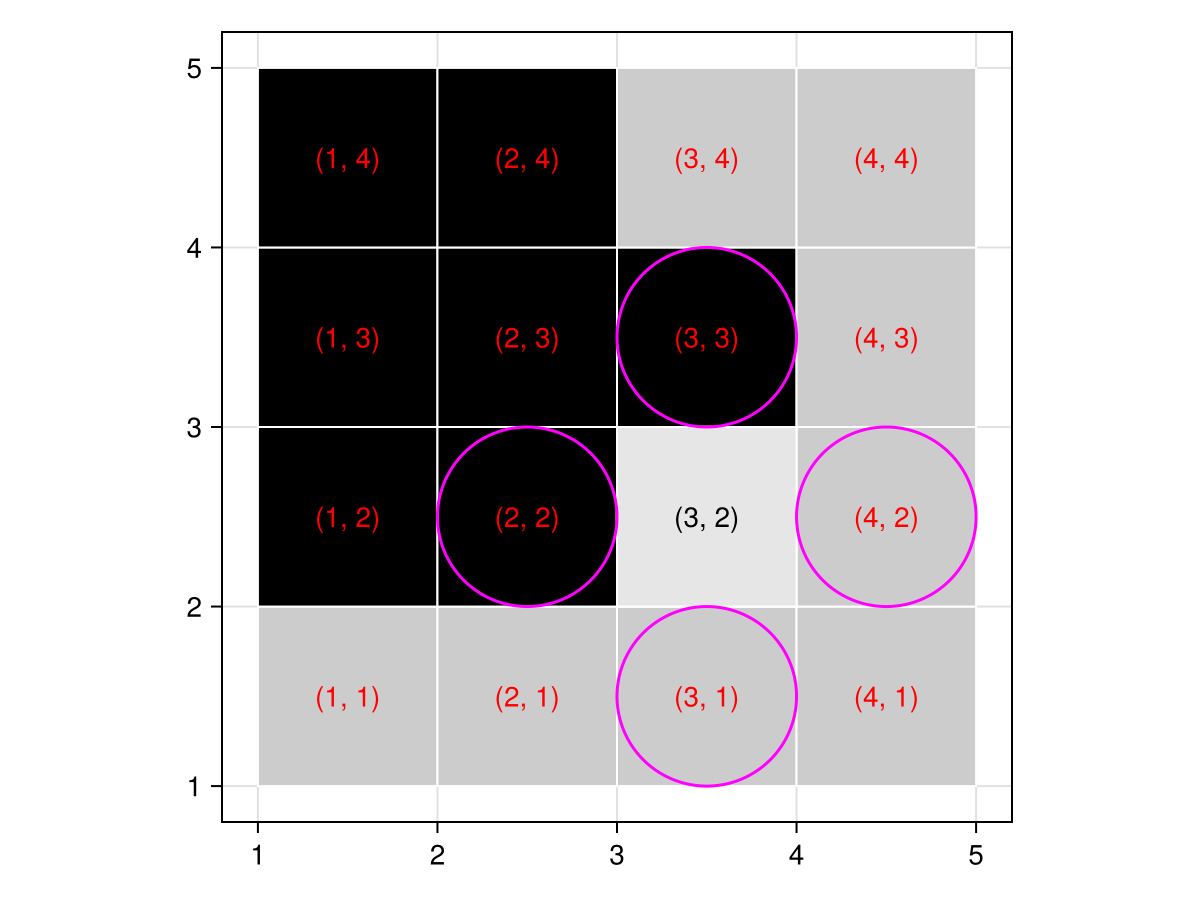

In [47]:
for n in neighbors
    arc!(ax,n.+(0.5,0.5),0.5,0,2*pi,color=RGBf(1,0,1))
end
fig

We begin with the first of these: (3,1).  It is pointing in the opposite direction as the original point

In [48]:
@show n1=pop!(neighbors)
@show spins[n1...]

n1 = pop!(neighbors) = (3, 1)
spins[n1...] = 1


1

That neigbor is pointing opposite $\sigma$, so we skip it.  The neighbor list is now one shorter:

neighbors = Tuple{Int32, Int32}[(2, 2), (3, 3), (4, 2)]


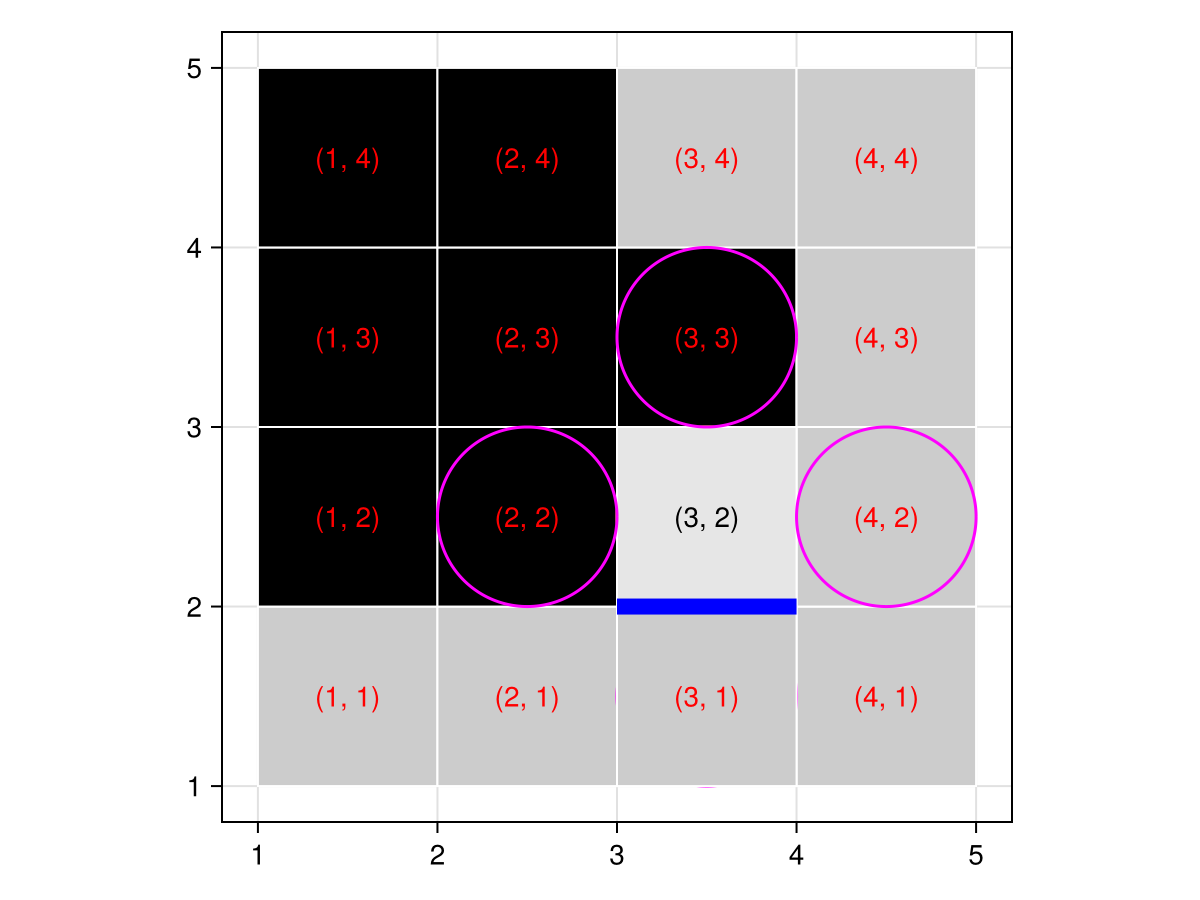

In [49]:
@show neighbors
function hline!(l,color)
    lines!(ax,[l,l.+(1,0)],color=color,linewidth=8)
end
pixel!(n1,RGBf(0.8,0.8,0.8),:red)
hline!(n1.+(0,1),RGBf(0,0,1))
fig

We look at the next neighbor

In [50]:
@show n2=pop!(neighbors)
@show spins[n2...]

n2 = pop!(neighbors) = (4, 2)
spins[n2...] = 1


1

That one is also ignored

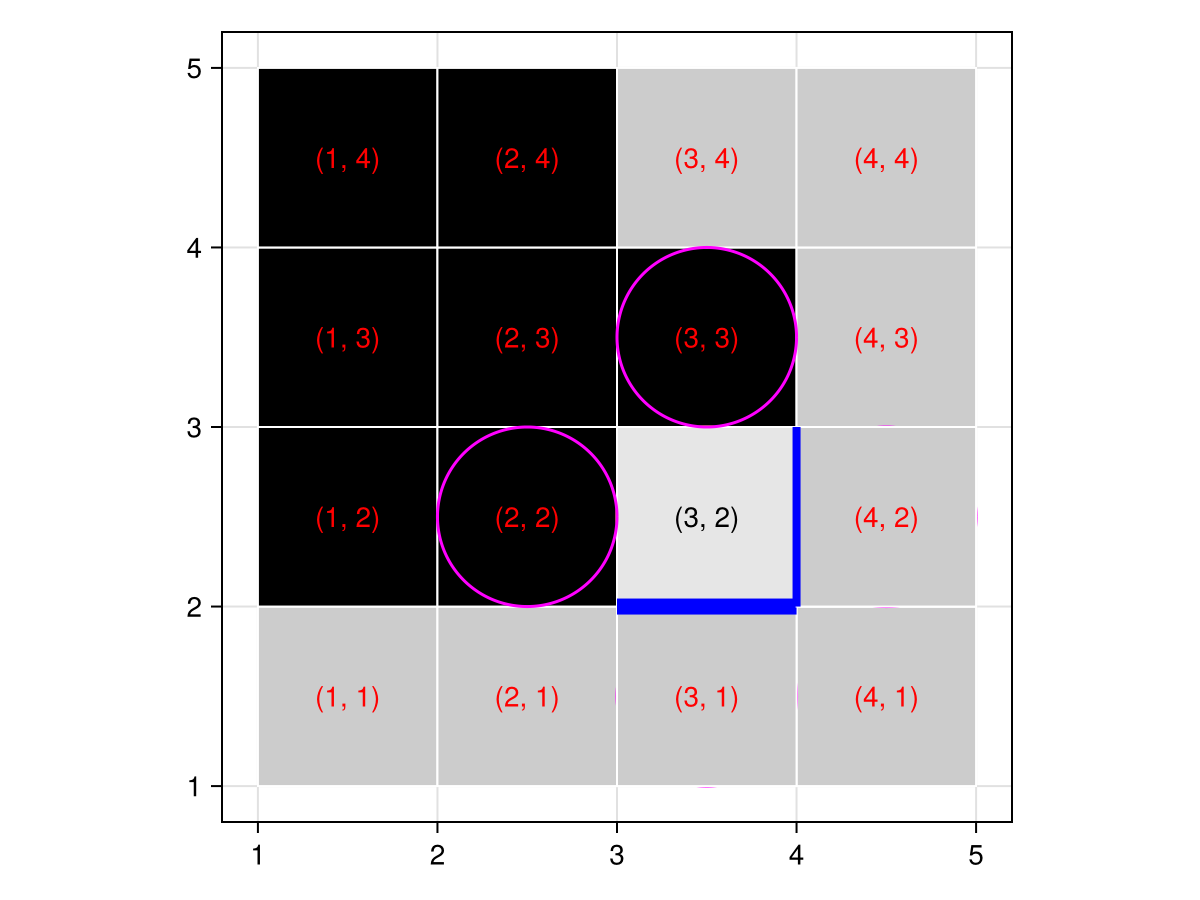

In [51]:
function vline!(l,color)
    lines!(ax,[l,l.+(0,1)],color=color,linewidth=4)
end
pixel!(n2,RGBf(0.8,0.8,0.8),:red)
vline!(n2,RGBf(0,0,1))
fig

We then move on to the next neighbor

In [52]:
@show n3=pop!(neighbors)
@show spins[n3...]

n3 = pop!(neighbors) = (3, 3)
spins[n3...] = -1


-1

This one we will flip with probability `p`.  Lets suppose that we roll a random number, and end up not adding it.  This occured with probability $1-p$. In our graph we will denote that with a red line.

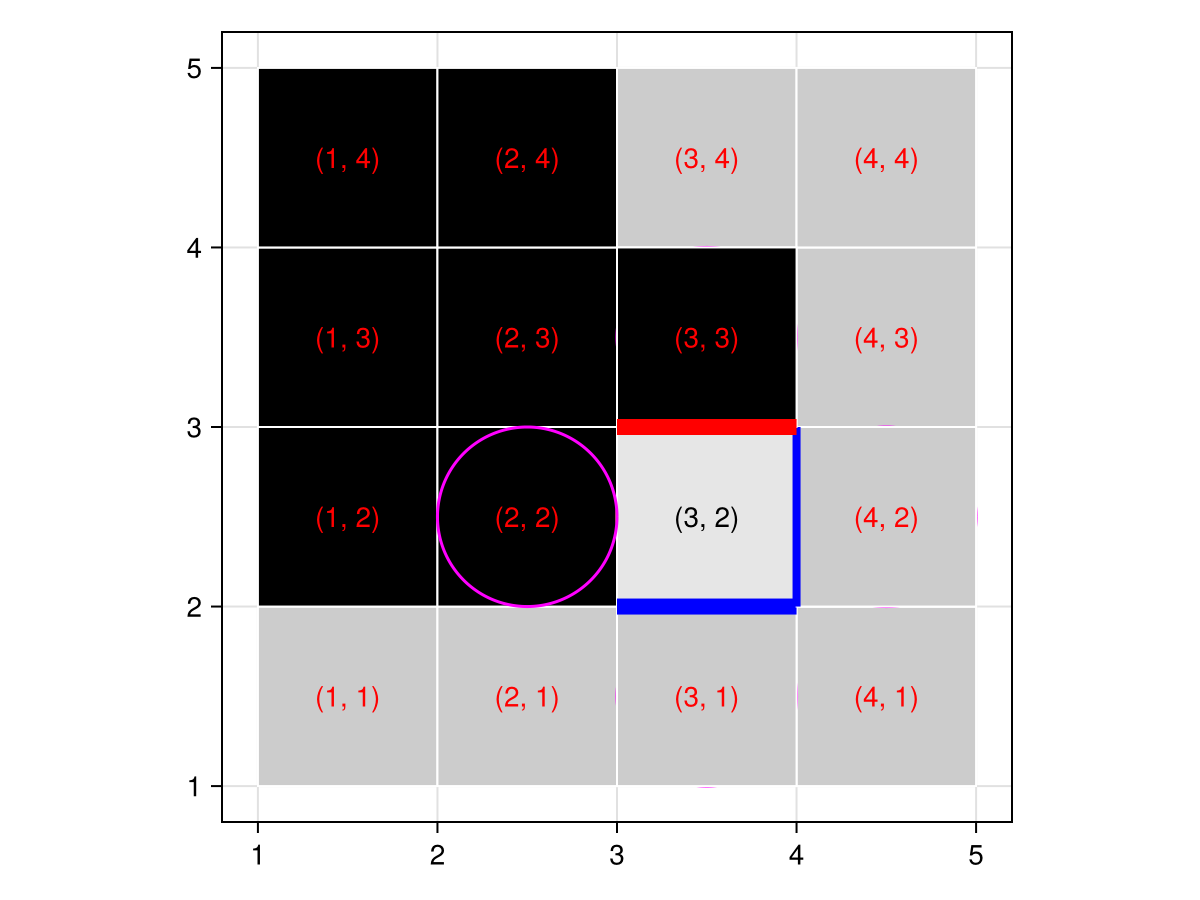

In [53]:
pixel!(n3,RGBf(0.,0.,0.),:red)
hline!(n3,:red)
fig

In [54]:
@show neighbors

neighbors = Tuple{Int32, Int32}[(2, 2)]


1-element Vector{Tuple{Int32, Int32}}:
 (2, 2)

The next one again we add with probability `p`.  Lets assume that this one we add.  Lets color its bond green, and add its neighbors to the `Array`.

n4 = pop!(neighbors) = (2, 2)


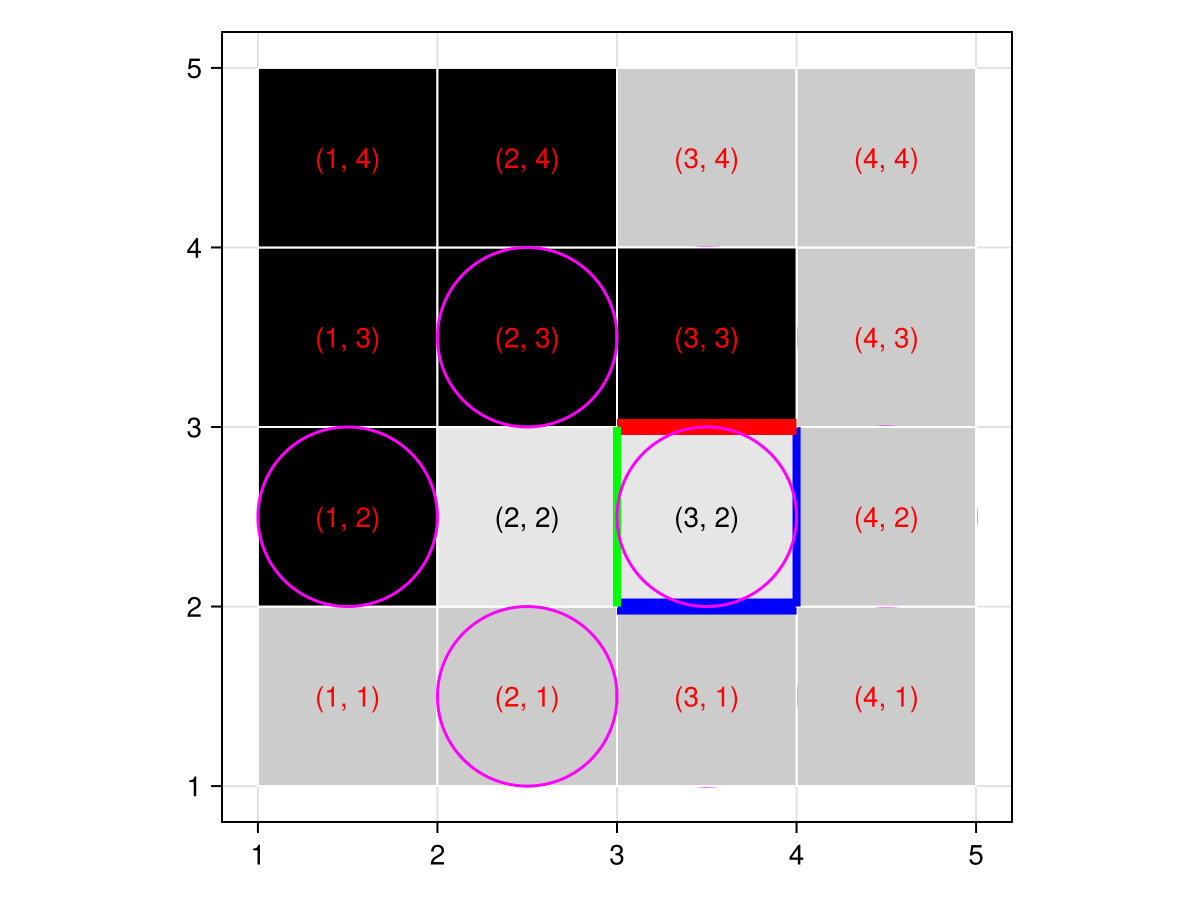

In [55]:
@show n4=pop!(neighbors)
spins[n4...]=-σ
pixel!(n4,RGBf(0.9,0.9,0.9),:black)
vline!(n4.+(1,0),RGBf(0,1,0))
addneighbors!(neighbors,n4)
for n in neighbors
    arc!(ax,n.+(0.5,0.5),0.5,0,2*pi,color=RGBf(1,0,1))
end
fig

We then keep going. Imagine we end up with:

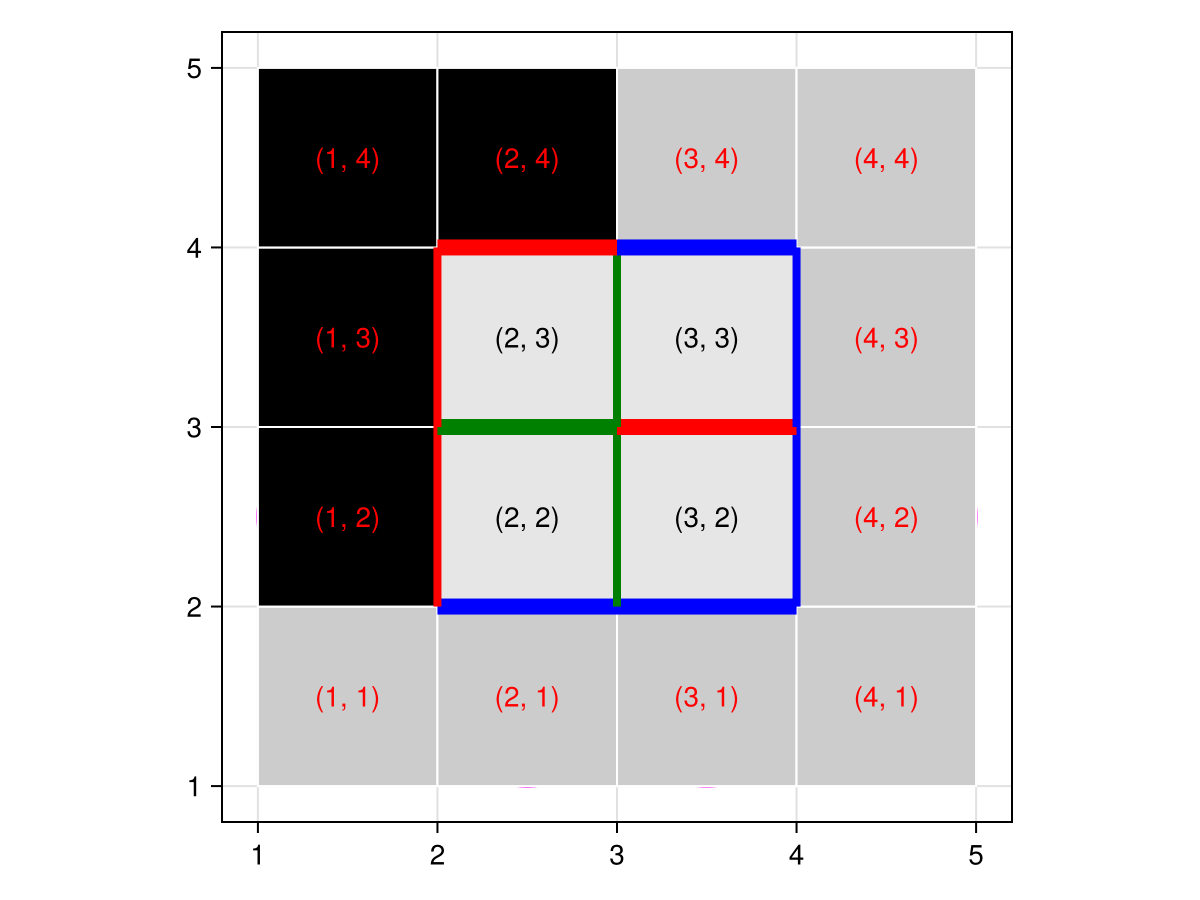

In [56]:
for i in CartesianIndices(spins)
    pixel!(i.I,c[start[i]],RGBf(1,0,0))
end
for i in [(3,2),(2,2),(2,3),(3,3)]
    pixel!(i,RGBf(0.9,0.9,0.9),RGBf(0,0,0))
end
hline!((3,2),:blue)
hline!((2,2),:blue)
vline!((2,2),:red)
vline!((3,2),:green)
vline!((4,2),:blue)
hline!((2,3),:green)
hline!((3,3),:red)
vline!((2,3),:red)
vline!((3,3),:green)
vline!((4,3),:blue)
hline!((2,4),:red)
hline!((3,4),:blue)
fig

The net probability of coming up with this configuration is 

\begin{align}
P=p^\mbox{Number of green lines}\,\, \bar{p}^\mbox{Number of red lines}
\end{align}

The reverse process would be

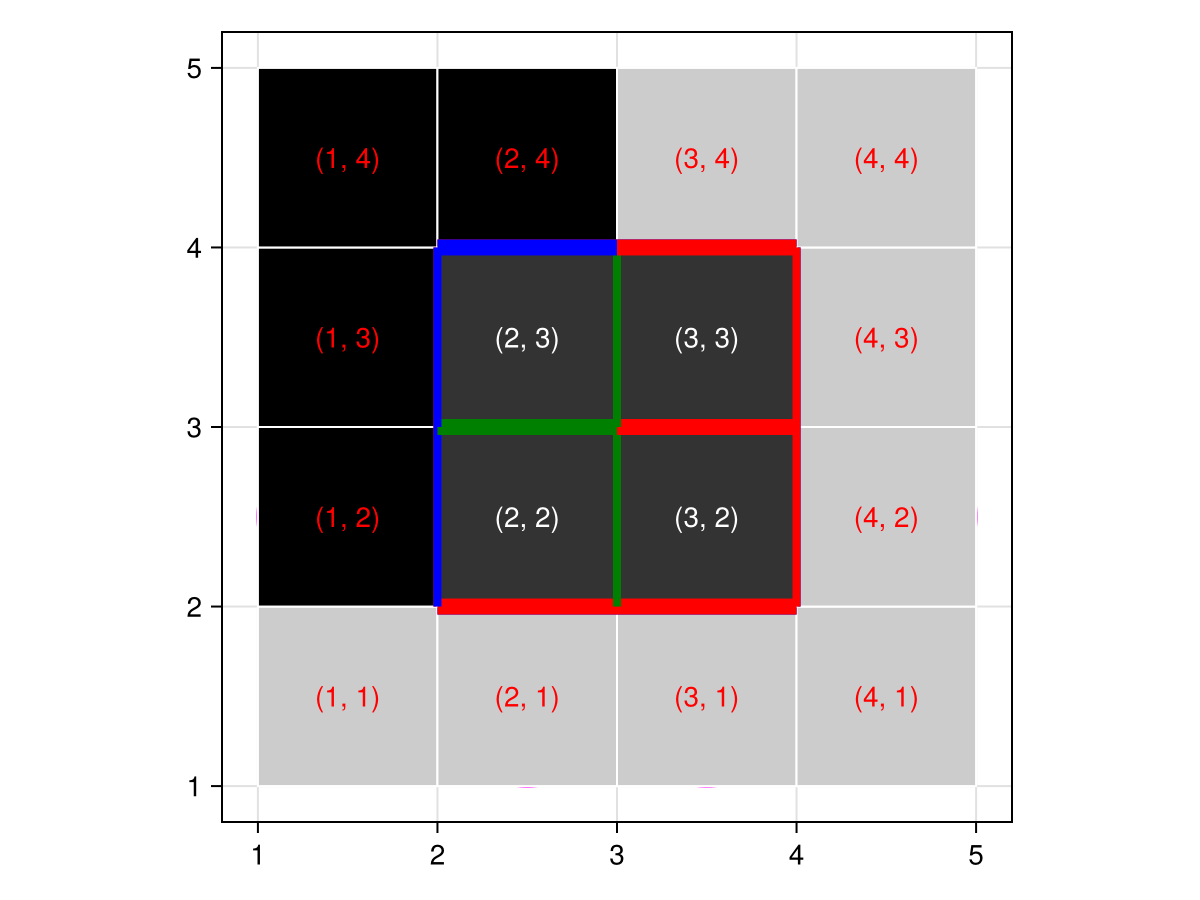

In [57]:
for i in [(3,2),(2,2),(2,3),(3,3)]
    pixel!(i,RGBf(0.2,0.2,0.2),RGBf(1,1,1))
end
hline!((3,2),:red)
hline!((2,2),:red)
vline!((2,2),:blue)
vline!((3,2),:green)
vline!((4,2),:red)
hline!((2,3),:green)
hline!((3,3),:red)
vline!((2,3),:blue)
vline!((3,3),:green)
vline!((4,3),:red)
hline!((2,4),:blue)
hline!((3,4),:red)
fig

All of the internal lines are the same, so the ratio of the forward and reverse process only depends on the boundary terms -- which exactly gives $\exp(-\beta \Delta E)$.

## Adding Magnetic Fields

The simplest way to add a field $h$ is to add a rejection step to the algorithm.  Every time that you flip a spin from $\sigma$ to $-\sigma$, you draw a random number $x\in [0,1]$.  If $x> e^{2\beta h \sigma}$, you abandon the whole cluster, resetting the spins to what they were before you started growing it.